In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Sequential, Linear, ReLU, Softmax
from torch.nn import functional as F
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng

from gmm import GMM
# circuit-sim
# import subcircuit as sc
# import PySpice.Logging.Logging as Logging
# logger = Logging.setup_logging()
# from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
# from PySpice.Unit import *
# from PySpice.Spice.NgSpice.Shared import NgSpiceShared
# mps_device = torch.device("mps")
mps_device = torch.device("cpu")

| Type | Value                          | Type | Value                              |
|------|--------------------------------|------|------------------------------------|
| Node | capacitance value              | Path | input transition time              |
|      | num of input nodes             |      | drive strength of drive cell       |
|      | total input cap                |      | functionality  of drive cell       |
|      | total output cap               |      | drive strength of load cell        |
|      | number of connected resistance |      | functionality of load cell         |
|      | total input resistance         |      | effective capacitance of load cell |
|      | total output resistance        |      | wire path Elmore delay             |
|      | ~~Elmore downstream capacitance~~  |      | wire path D2M delay                |
|      | ~~Elmore stage delay~~             |      |                                    |

$$x_i^{l_1} = ReLU(W_1^{l_1}x_i^{l_1-1}+W_2^{l_1}a_{iu}\sum_{u\in \mathcal{N}(v_i)}x_u^{l_1-1})$$

In [2]:
from torch_geometric.utils import to_dense_adj

# torch random seed
torch.manual_seed(42)


class L1_GNNModule(nn.Module):
    """
    Modified GraphSAGE module with weighted aggregation
    """

    def __init__(self, num_output_features):
        super().__init__()
        self.W1 = nn.Parameter(
            torch.randn(num_output_features, num_output_features)
        ).to(mps_device)
        self.W2 = nn.Parameter(
            torch.randn(num_output_features, num_output_features)
        ).to(mps_device)

        nn.init.xavier_uniform_(self.W2, gain=1.414).to(mps_device)
        nn.init.xavier_uniform_(self.W1, gain=1.414).to(mps_device)

    def forward(self, x, edge_index, edge_weight):
        neighbors_agg = (
            to_dense_adj(edge_index, edge_attr=edge_weight).squeeze(0).to(mps_device)
        )
        neighbors_agg = torch.matmul(
            neighbors_agg.float(), x.float().to(mps_device)
        ).to(mps_device)
        # linear transformation
        out = torch.matmul(
            neighbors_agg.to(torch.float32).to(mps_device), self.W2.to(torch.float32).to(mps_device)
        ) + torch.matmul(x.to(torch.float32).to(mps_device), self.W1.to(torch.float32).to(mps_device))
        # relu activation
        out = torch.relu(out)
        # use leaky relu
        # out = F.leaky_relu(out)
        return out

$$\tilde{a}_{iu}^{(k, l_2)} = softmax(\frac{W_Q^{(k, l_2)}x_i^{(L_1+l_2-1)}(W_k^{(k,l_2)}x_u^{(L_1+l_2-1)})}{\sqrt{d_k}})$$

$$x_i^{(L_1+l_2)} = x_i^{(L_1+l_2-1)} +  W_3^{(l_2)}||^{\mathcal{K}}_{k=1}\sum_{u\in \mathcal{V}}\tilde{a}_{iu}^{(k, l_2)}(W_V^{(k, l_2)}x_u^{(L_1+l_2-1)})$$


In [3]:
class L2_GNNModule(nn.Module):
    """Multi-head Attention GNN module
    """
    def __init__(self, num_output_features, num_of_heads=4):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn(num_of_heads, num_output_features, num_output_features)).to(torch.float32).to(mps_device)
        self.Wk = nn.Parameter(torch.randn(num_of_heads, num_output_features, num_output_features)).to(torch.float32).to(mps_device)
        self.Wv = nn.Parameter(torch.randn(num_of_heads, num_output_features, num_output_features)).to(torch.float32).to(mps_device)
        self.W3 = nn.Parameter(torch.randn(num_output_features, num_output_features)).to(torch.float32).to(mps_device)
        self.num_of_heads = num_of_heads
        self.num_output_features = num_output_features

        nn.init.xavier_uniform_(self.Wq, gain=1.414).to(mps_device)
        nn.init.xavier_uniform_(self.Wk, gain=1.414).to(mps_device)
        nn.init.xavier_uniform_(self.Wv, gain=1.414).to(mps_device)
        nn.init.xavier_uniform_(self.W3, gain=1.414).to(mps_device)

    def forward(self, x):
        # self-attention map A
        x = x.to(torch.float32)
        q = torch.matmul(x, self.Wq)
        q = q.view(-1, self.num_of_heads, self.num_output_features)
        k = torch.matmul(x, self.Wk)
        k = k.view(-1, self.num_of_heads, self.num_output_features)
        v = torch.matmul(x, self.Wv)
        v = v.view(-1, self.num_of_heads, self.num_output_features)

        # transpose to num_of_heads * num_nodes * num_node_features
        q = q.transpose(0,1)
        k = k.transpose(0,1)
        v = v.transpose(0,1)

        d_k = torch.tensor(self.num_output_features, dtype=torch.float)
        a_iu = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(d_k)
        a_iu = torch.softmax(a_iu, dim=-1)
        a_iu = torch.matmul(a_iu, v)

        # concat heads
        concat = a_iu.contiguous().view(self.num_of_heads, -1, self.num_output_features)
        
        # reshape to num_nodes * num_node_features by averaging over heads
        concat = concat.transpose(0,1)
        concat = concat.mean(dim=1)
        l2 = torch.matmul(concat, self.W3)
        x = x + l2

        return x

In [4]:
class GNNtrans(nn.Module):
    def __init__(self, num_node_features, num_path_features) -> None:
        super().__init__()
        self.num_node_features = num_node_features
        self.num_path_features = num_path_features
        self.gnn1 = L1_GNNModule(num_node_features)
        self.gnn2 = L1_GNNModule(num_node_features)
        self.gnn3 = L1_GNNModule(num_node_features)
        self.gnn4 = L1_GNNModule(num_node_features)
        self.gnn5 = L1_GNNModule(num_node_features)
        self.trans1 = L2_GNNModule(num_node_features, num_of_heads=4)
        self.trans2 = L2_GNNModule(num_node_features, num_of_heads=4)
        self.trans3 = L2_GNNModule(num_node_features, num_of_heads=4)
        # MLP layer predicting slew and delay
        self.linear_slew = nn.Linear(num_node_features + num_path_features, 1)
        self.linear_delay = nn.Linear(num_node_features + num_path_features + 1, 1)
        # initialize weights
        nn.init.xavier_uniform_(self.linear_slew.weight, gain=1.414).to(mps_device)
        nn.init.xavier_uniform_(self.linear_delay.weight, gain=1.414).to(mps_device)

    def forward(self, x, edge_index, edge_weight, path_indices, path_features):
        x_1 = self.gnn1(x, edge_index, edge_weight)
        x_1 = self.gnn2(x_1, edge_index, edge_weight)
        x_1 = self.gnn3(x_1, edge_index, edge_weight)
        x_1 = self.gnn4(x_1, edge_index, edge_weight)
        x_1 = self.gnn5(x_1, edge_index, edge_weight)
        x_2 = self.trans1(x_1)
        x_2 = self.trans2(x_2)
        x_2 = self.trans3(x_2)
        
        # path aggregation
        y = []
        for path_index, path_feature in zip(path_indices, path_features):
            # select node based on path index
            x_path = torch.index_select(x_2, 0, path_index)
            # average pooling based on each path
            x_path = torch.mean(x_path, dim=0)
            # concatenate with path features
            x_path = torch.cat((x_path, path_feature))
            # add a dimension
            x_path = x_path.unsqueeze(0)
            # append to output
            y.append(x_path[0])
        
        # convert to tensor
        y = torch.stack(y)
        # predict slew
        slew = self.linear_slew(y)
        # concatenate slew with path features
        y = torch.cat((y, slew), dim=1)
        # predict delay
        delay = self.linear_delay(y)

        return slew, delay

In [5]:
# '''Test the GNN'''
# # input features from node attributes
# x = torch.tensor([[G.nodes[i]['capacitance'],
#                     G.nodes[i]['num_input_nodes'],
#                     G.nodes[i]['input_cap'],
#                     G.nodes[i]['output_cap'],
#                     G.nodes[i]['connected_resistance'],
#                     G.nodes[i]['input_resistance'],
#                     G.nodes[i]['output_resistance'],
#                     G.nodes[i]['elmore_cap'],
#                     G.nodes[i]['elmore_delay']] for i in range(num_nodes)], dtype=torch.float)

# # extract edge index from adjacency matrix from networkx
# edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if M_adj.A[i,j] != 0], dtype=torch.long).t()

# print(edge_index)

# # extract edge weights from networkx
# edge_weight = torch.tensor([G.edges[i,j]['weight'] for i in range(num_nodes) for j in range(num_nodes) if M_adj.A[i,j] != 0], dtype=torch.float)

# # extract path indices from networkx : node along the path
# all_path_indices = torch.tensor(list_of_paths, dtype=torch.long)

# # extract path features from networkx
# path_features = M_path
                                
# num_path_features = path_features.shape[1]

# gnn = GNNtrans(num_node_features, num_node_features, num_path_features)
# slew, delay = gnn(x, edge_index, edge_weight, all_path_indices, path_features)

# slew_target = 0.1
# slew_target = torch.tensor(slew_target, dtype=torch.float)
# delay_target = 0.2
# delay_target = torch.tensor(delay_target, dtype=torch.float)

# print("Slew: ", slew)
# print("Slew Shape: ", slew.shape)

# print("Delay: ", delay)
# print("Delay Shape: ", delay.shape)

# print("x Shape: ", x.shape)
# print("edge_index Shape: ", edge_index.shape)
# print("edge_weight Shape: ", edge_weight.shape)
# print("path_indices Shape: ", all_path_indices.shape)
# print("path_features Shape: ", path_features.shape)
# print("slew_target Shape: ", slew_target.shape)
# print("delay_target Shape: ", delay_target.shape)


## Sample Extraction

In [6]:
# import numpy as np 
# import os

# train_size = 8000
# test_size = 2000

# # extract sample from path
# SAMPLE_DIR = "./sample/Data/"
# TRAIN_DIR = "./sample/Train/"
# TEST_DIR = "./sample/Test/"

# # 8 stage
# label_delay_stage8 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage8_label_delay.npy"))
# label_delay_stage8 = torch.from_numpy(label_delay_stage8)
# label_delay_stage8 = label_delay_stage8.to(torch.float32).to(mps_device)
# label_slew_stage8 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage8_label_slew.npy"))
# label_slew_stage8 = torch.from_numpy(label_slew_stage8)
# label_slew_stage8 = label_slew_stage8.to(torch.float32).to(mps_device)
# all_node_feature_stage8 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage8_node_features.npy"))
# all_node_feature_stage8 = torch.from_numpy(all_node_feature_stage8).to(torch.float32).to(mps_device)
# all_path_feature_stage8 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage8_path_features.npy"))
# all_path_feature_stage8 = np.expand_dims(all_path_feature_stage8, axis=1)
# all_path_feature_stage8 = torch.from_numpy(all_path_feature_stage8).to(torch.float32).to(mps_device)
# all_edge_index_stage8 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage8_edge_index.npy"))
# all_edge_index_stage8 = torch.from_numpy(all_edge_index_stage8).to(torch.long).to(mps_device)
# all_edge_weight_stage8 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage8_edge_weight.npy"))
# all_edge_weight_stage8 = torch.from_numpy(all_edge_weight_stage8).to(torch.float32).to(mps_device)
# all_path_indices_stage8 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage8_path_indices.npy"))
# all_path_indices_stage8 = torch.from_numpy(all_path_indices_stage8).to(torch.long).to(mps_device)

# print("label_delay_stage8: ", label_delay_stage8.shape)
# print("label_slew_stage8: ", label_slew_stage8.shape)
# print("all_node_feature_stage8: ", all_node_feature_stage8.shape)
# print("all_path_feature_stage8: ", all_path_feature_stage8.shape)
# print("all_edge_index_stage8: ", all_edge_index_stage8.shape)
# print("all_edge_weight_stage8: ", all_edge_weight_stage8.shape)
# print("all_path_indices_stage8: ", all_path_indices_stage8.shape)
# print("---------------------------------")

# # train test split 8 stage
# train_delay_stage8, test_delay_stage8 = torch.utils.data.random_split(label_delay_stage8, [train_size, test_size])
# train_slew_stage8, test_slew_stage8 = torch.utils.data.random_split(label_slew_stage8, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_node_feature_stage8, test_node_feature_stage8 = torch.utils.data.random_split(all_node_feature_stage8, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_path_feature_stage8, test_path_feature_stage8 = torch.utils.data.random_split(all_path_feature_stage8, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_edge_index_stage8, test_edge_index_stage8 = torch.utils.data.random_split(all_edge_index_stage8, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_edge_weight_stage8, test_edge_weight_stage8 = torch.utils.data.random_split(all_edge_weight_stage8, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_path_indices_stage8, test_path_indices_stage8 = torch.utils.data.random_split(all_path_indices_stage8, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# # save train test split 8 stage with pytorch
# torch.save(train_delay_stage8, os.path.join(TRAIN_DIR, "train_delay_stage8.pt"))
# torch.save(train_slew_stage8, os.path.join(TRAIN_DIR, "train_slew_stage8.pt"))
# torch.save(train_node_feature_stage8, os.path.join(TRAIN_DIR, "train_node_feature_stage8.pt"))
# torch.save(train_path_feature_stage8, os.path.join(TRAIN_DIR, "train_path_feature_stage8.pt"))
# torch.save(train_edge_index_stage8, os.path.join(TRAIN_DIR, "train_edge_index_stage8.pt"))
# torch.save(train_edge_weight_stage8, os.path.join(TRAIN_DIR, "train_edge_weight_stage8.pt"))
# torch.save(train_path_indices_stage8, os.path.join(TRAIN_DIR, "train_path_indices_stage8.pt"))
# torch.save(test_delay_stage8, os.path.join(TEST_DIR, "test_delay_stage8.pt"))
# torch.save(test_slew_stage8, os.path.join(TEST_DIR, "test_slew_stage8.pt"))
# torch.save(test_node_feature_stage8, os.path.join(TEST_DIR, "test_node_feature_stage8.pt"))
# torch.save(test_path_feature_stage8, os.path.join(TEST_DIR, "test_path_feature_stage8.pt"))
# torch.save(test_edge_index_stage8, os.path.join(TEST_DIR, "test_edge_index_stage8.pt"))
# torch.save(test_edge_weight_stage8, os.path.join(TEST_DIR, "test_edge_weight_stage8.pt"))
# torch.save(test_path_indices_stage8, os.path.join(TEST_DIR, "test_path_indices_stage8.pt"))

# # 6 stage
# label_delay_stage6 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage6_label_delay.npy"))
# label_delay_stage6 = torch.from_numpy(label_delay_stage6)
# label_delay_stage6 = label_delay_stage6.to(torch.float32).to(mps_device)
# label_slew_stage6 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage6_label_slew.npy"))
# label_slew_stage6 = torch.from_numpy(label_slew_stage6)
# label_slew_stage6 = label_slew_stage6.to(torch.float32).to(mps_device)
# all_node_feature_stage6 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage6_node_features.npy"))
# all_node_feature_stage6 = torch.from_numpy(all_node_feature_stage6).to(torch.float32).to(mps_device)
# all_path_feature_stage6 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage6_path_features.npy"))
# all_path_feature_stage6 = np.expand_dims(all_path_feature_stage6, axis=1)
# all_path_feature_stage6 = torch.from_numpy(all_path_feature_stage6).to(torch.float32).to(mps_device)
# all_edge_index_stage6 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage6_edge_index.npy"))
# all_edge_index_stage6 = torch.from_numpy(all_edge_index_stage6).to(torch.long).to(mps_device)
# all_edge_weight_stage6 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage6_edge_weight.npy"))
# all_edge_weight_stage6 = torch.from_numpy(all_edge_weight_stage6).to(torch.float32).to(mps_device)
# all_path_indices_stage6 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage6_path_indices.npy"))
# all_path_indices_stage6 = torch.from_numpy(all_path_indices_stage6).to(torch.long).to(mps_device)

# print("label_delay_stage6: ", label_delay_stage6.shape)
# print("label_slew_stage6: ", label_slew_stage6.shape)
# print("all_node_feature_stage6: ", all_node_feature_stage6.shape)
# print("all_path_feature_stage6: ", all_path_feature_stage6.shape)
# print("all_edge_index_stage6: ", all_edge_index_stage6.shape)
# print("all_edge_weight_stage6: ", all_edge_weight_stage6.shape)
# print("all_path_indices_stage6: ", all_path_indices_stage6.shape)
# print("---------------------------------")

# # train test split 6 stage
# train_delay_stage6, test_delay_stage6 = torch.utils.data.random_split(label_delay_stage6, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_slew_stage6, test_slew_stage6 = torch.utils.data.random_split(label_slew_stage6, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_node_feature_stage6, test_node_feature_stage6 = torch.utils.data.random_split(all_node_feature_stage6, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_path_feature_stage6, test_path_feature_stage6 = torch.utils.data.random_split(all_path_feature_stage6, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_edge_index_stage6, test_edge_index_stage6 = torch.utils.data.random_split(all_edge_index_stage6, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_edge_weight_stage6, test_edge_weight_stage6 = torch.utils.data.random_split(all_edge_weight_stage6, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_path_indices_stage6, test_path_indices_stage6 = torch.utils.data.random_split(all_path_indices_stage6, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# # save train test split 6 stage
# torch.save(train_delay_stage6, os.path.join(TRAIN_DIR, "train_delay_stage6.pt"))
# torch.save(train_slew_stage6, os.path.join(TRAIN_DIR, "train_slew_stage6.pt"))
# torch.save(train_node_feature_stage6, os.path.join(TRAIN_DIR, "train_node_feature_stage6.pt"))
# torch.save(train_path_feature_stage6, os.path.join(TRAIN_DIR, "train_path_feature_stage6.pt"))
# torch.save(train_edge_index_stage6, os.path.join(TRAIN_DIR, "train_edge_index_stage6.pt"))
# torch.save(train_edge_weight_stage6, os.path.join(TRAIN_DIR, "train_edge_weight_stage6.pt"))
# torch.save(train_path_indices_stage6, os.path.join(TRAIN_DIR, "train_path_indices_stage6.pt"))
# torch.save(test_delay_stage6, os.path.join(TEST_DIR, "test_delay_stage6.pt"))
# torch.save(test_slew_stage6, os.path.join(TEST_DIR, "test_slew_stage6.pt"))
# torch.save(test_node_feature_stage6, os.path.join(TEST_DIR, "test_node_feature_stage6.pt"))
# torch.save(test_path_feature_stage6, os.path.join(TEST_DIR, "test_path_feature_stage6.pt"))
# torch.save(test_edge_index_stage6, os.path.join(TEST_DIR, "test_edge_index_stage6.pt"))
# torch.save(test_edge_weight_stage6, os.path.join(TEST_DIR, "test_edge_weight_stage6.pt"))
# torch.save(test_path_indices_stage6, os.path.join(TEST_DIR, "test_path_indices_stage6.pt"))

# # 4 stage
# label_delay_stage4 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage4_label_delay.npy"))
# label_delay_stage4 = torch.from_numpy(label_delay_stage4)
# label_delay_stage4 = label_delay_stage4.to(torch.float32).to(mps_device)
# label_slew_stage4 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage4_label_slew.npy"))
# label_slew_stage4 = torch.from_numpy(label_slew_stage4)
# label_slew_stage4 = label_slew_stage4.to(torch.float32).to(mps_device)
# all_node_feature_stage4 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage4_node_features.npy"))
# all_node_feature_stage4 = torch.from_numpy(all_node_feature_stage4).to(torch.float32).to(mps_device)
# all_path_feature_stage4 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage4_path_features.npy"))
# all_path_feature_stage4 = np.expand_dims(all_path_feature_stage4, axis=1)
# all_path_feature_stage4 = torch.from_numpy(all_path_feature_stage4).to(torch.float32).to(mps_device)
# all_edge_index_stage4 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage4_edge_index.npy"))
# all_edge_index_stage4 = torch.from_numpy(all_edge_index_stage4).to(torch.long).to(mps_device)
# all_edge_weight_stage4 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage4_edge_weight.npy"))
# all_edge_weight_stage4 = torch.from_numpy(all_edge_weight_stage4).to(torch.float32).to(mps_device)
# all_path_indices_stage4 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage4_path_indices.npy"))
# all_path_indices_stage4 = torch.from_numpy(all_path_indices_stage4).to(torch.long).to(mps_device)

# print("label_delay_stage4: ", label_delay_stage4.shape)
# print("label_slew_stage4: ", label_slew_stage4.shape)
# print("all_node_feature_stage4: ", all_node_feature_stage4.shape)
# print("all_path_feature_stage4: ", all_path_feature_stage4.shape)
# print("all_edge_index_stage4: ", all_edge_index_stage4.shape)
# print("all_edge_weight_stage4: ", all_edge_weight_stage4.shape)
# print("all_path_indices_stage4: ", all_path_indices_stage4.shape)
# print("---------------------------------")

# # train test split 4 stage
# train_delay_stage4, test_delay_stage4 = torch.utils.data.random_split(label_delay_stage4, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_slew_stage4, test_slew_stage4 = torch.utils.data.random_split(label_slew_stage4, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_node_feature_stage4, test_node_feature_stage4 = torch.utils.data.random_split(all_node_feature_stage4, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_path_feature_stage4, test_path_feature_stage4 = torch.utils.data.random_split(all_path_feature_stage4, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_edge_index_stage4, test_edge_index_stage4 = torch.utils.data.random_split(all_edge_index_stage4, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_edge_weight_stage4, test_edge_weight_stage4 = torch.utils.data.random_split(all_edge_weight_stage4, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_path_indices_stage4, test_path_indices_stage4 = torch.utils.data.random_split(all_path_indices_stage4, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# # save train test split 4 stage
# torch.save(train_delay_stage4, os.path.join(TRAIN_DIR, "train_delay_stage4.pt"))
# torch.save(train_slew_stage4, os.path.join(TRAIN_DIR, "train_slew_stage4.pt"))
# torch.save(train_node_feature_stage4, os.path.join(TRAIN_DIR, "train_node_feature_stage4.pt"))
# torch.save(train_path_feature_stage4, os.path.join(TRAIN_DIR, "train_path_feature_stage4.pt"))
# torch.save(train_edge_index_stage4, os.path.join(TRAIN_DIR, "train_edge_index_stage4.pt"))
# torch.save(train_edge_weight_stage4, os.path.join(TRAIN_DIR, "train_edge_weight_stage4.pt"))
# torch.save(train_path_indices_stage4, os.path.join(TRAIN_DIR, "train_path_indices_stage4.pt"))
# torch.save(test_delay_stage4, os.path.join(TEST_DIR, "test_delay_stage4.pt"))
# torch.save(test_slew_stage4, os.path.join(TEST_DIR, "test_slew_stage4.pt"))
# torch.save(test_node_feature_stage4, os.path.join(TEST_DIR, "test_node_feature_stage4.pt"))
# torch.save(test_path_feature_stage4, os.path.join(TEST_DIR, "test_path_feature_stage4.pt"))
# torch.save(test_edge_index_stage4, os.path.join(TEST_DIR, "test_edge_index_stage4.pt"))
# torch.save(test_edge_weight_stage4, os.path.join(TEST_DIR, "test_edge_weight_stage4.pt"))
# torch.save(test_path_indices_stage4, os.path.join(TEST_DIR, "test_path_indices_stage4.pt"))

# # 2 stage
# label_delay_stage2 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage2_label_delay.npy"))
# label_delay_stage2 = torch.from_numpy(label_delay_stage2)
# label_delay_stage2 = label_delay_stage2.to(torch.float32).to(mps_device)
# label_slew_stage2 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage2_label_slew.npy"))
# label_slew_stage2 = torch.from_numpy(label_slew_stage2)
# label_slew_stage2 = label_slew_stage2.to(torch.float32).to(mps_device)
# all_node_feature_stage2 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage2_node_features.npy"))
# all_node_feature_stage2 = torch.from_numpy(all_node_feature_stage2).to(torch.float32).to(mps_device)
# all_path_feature_stage2 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage2_path_features.npy"))
# all_path_feature_stage2 = np.expand_dims(all_path_feature_stage2, axis=1)
# all_path_feature_stage2 = torch.from_numpy(all_path_feature_stage2).to(torch.float32).to(mps_device)
# all_edge_index_stage2 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage2_edge_index.npy"))
# all_edge_index_stage2 = torch.from_numpy(all_edge_index_stage2).to(torch.long).to(mps_device)
# all_edge_weight_stage2 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage2_edge_weight.npy"))
# all_edge_weight_stage2 = torch.from_numpy(all_edge_weight_stage2).to(torch.float32).to(mps_device)
# all_path_indices_stage2 = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage2_path_indices.npy"))
# all_path_indices_stage2 = torch.from_numpy(all_path_indices_stage2).to(torch.long).to(mps_device)

# print("label_delay_stage2: ", label_delay_stage2.shape)
# print("label_slew_stage2: ", label_slew_stage2.shape)
# print("all_node_feature_stage2: ", all_node_feature_stage2.shape)
# print("all_path_feature_stage2: ", all_path_feature_stage2.shape)
# print("all_edge_index_stage2: ", all_edge_index_stage2.shape)
# print("all_edge_weight_stage2: ", all_edge_weight_stage2.shape)
# print("all_path_indices_stage2: ", all_path_indices_stage2.shape)
# print("---------------------------------")

# # train test split 2 stage
# train_delay_stage2, test_delay_stage2 = torch.utils.data.random_split(label_delay_stage2, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_slew_stage2, test_slew_stage2 = torch.utils.data.random_split(label_slew_stage2, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_node_feature_stage2, test_node_feature_stage2 = torch.utils.data.random_split(all_node_feature_stage2, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_path_feature_stage2, test_path_feature_stage2 = torch.utils.data.random_split(all_path_feature_stage2, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_edge_index_stage2, test_edge_index_stage2 = torch.utils.data.random_split(all_edge_index_stage2, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_edge_weight_stage2, test_edge_weight_stage2 = torch.utils.data.random_split(all_edge_weight_stage2, [train_size, test_size], generator=torch.Generator().manual_seed(42))
# train_path_indices_stage2, test_path_indices_stage2 = torch.utils.data.random_split(all_path_indices_stage2, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# # save train test split 2 stage
# torch.save(train_delay_stage2, os.path.join(TRAIN_DIR, "train_delay_stage2.pt"))
# torch.save(train_slew_stage2, os.path.join(TRAIN_DIR, "train_slew_stage2.pt"))
# torch.save(train_node_feature_stage2, os.path.join(TRAIN_DIR, "train_node_feature_stage2.pt"))
# torch.save(train_path_feature_stage2, os.path.join(TRAIN_DIR, "train_path_feature_stage2.pt"))
# torch.save(train_edge_index_stage2, os.path.join(TRAIN_DIR, "train_edge_index_stage2.pt"))
# torch.save(train_edge_weight_stage2, os.path.join(TRAIN_DIR, "train_edge_weight_stage2.pt"))
# torch.save(train_path_indices_stage2, os.path.join(TRAIN_DIR, "train_path_indices_stage2.pt"))
# torch.save(test_delay_stage2, os.path.join(TEST_DIR, "test_delay_stage2.pt"))
# torch.save(test_slew_stage2, os.path.join(TEST_DIR, "test_slew_stage2.pt"))
# torch.save(test_node_feature_stage2, os.path.join(TEST_DIR, "test_node_feature_stage2.pt"))
# torch.save(test_path_feature_stage2, os.path.join(TEST_DIR, "test_path_feature_stage2.pt"))
# torch.save(test_edge_index_stage2, os.path.join(TEST_DIR, "test_edge_index_stage2.pt"))
# torch.save(test_edge_weight_stage2, os.path.join(TEST_DIR, "test_edge_weight_stage2.pt"))
# torch.save(test_path_indices_stage2, os.path.join(TEST_DIR, "test_path_indices_stage2.pt"))

# # concat all samples
# # label_delay = label_delay_stage2
# # label_slew = label_slew_stage2
# # all_node_feature = all_node_feature_stage2
# # all_path_feature = all_node_feature_stage2
# # all_edge_index = all_edge_index_stage2
# # all_edge_weight = all_edge_weight_stage2
# # all_path_indices = all_path_indices_stage2

# # label_delay = torch.cat((label_delay_stage2, label_delay_stage4, label_delay_stage6, label_delay_stage8), dim=0)
# # label_slew = torch.cat((label_slew_stage2, label_slew_stage4, label_slew_stage6, label_slew_stage8), dim=0)
# # all_node_feature = torch.cat((all_node_feature_stage2, all_node_feature_stage4, all_node_feature_stage6, all_node_feature_stage8), dim=1)
# # all_path_feature = torch.cat((all_path_feature_stage2, all_path_feature_stage4, all_path_feature_stage6, all_path_feature_stage8), dim=1)
# # all_edge_index = torch.cat((all_edge_index_stage2, all_edge_index_stage4, all_edge_index_stage6, all_edge_index_stage8), dim=2)
# # all_edge_weight = torch.cat((all_edge_weight_stage2, all_edge_weight_stage4, all_edge_weight_stage6, all_edge_weight_stage8), dim=1)
# # all_path_indices = torch.cat((all_path_indices_stage2, all_path_indices_stage4, all_path_indices_stage6, all_path_indices_stage8), dim=2)

# print("\n")
# # print("label_delay Shape: ", label_delay.shape)
# # print("label_slew Shape: ", label_slew.shape)
# # print("node_feature Shape: ", all_node_feature.shape)
# # print("path_feature Shape: ", all_path_feature.shape)
# # print("edge_index Shape: ", all_edge_index.shape)
# # print("edge_weight Shape: ", all_edge_weight.shape)
# # print("path_indices Shape: ", all_path_indices.shape)
    

In [7]:
import os

SAMPLE_DIR = "./sample/Data/"
TRAIN_DIR = "./sample/Train/"
TEST_DIR = "./sample/Test/"

label_delay = [
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_delay_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_delay_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_delay_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_delay_stage8.pt"))])
]
label_slew = [
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_slew_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_slew_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_slew_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_slew_stage8.pt"))])
]
all_node_feature = [
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_node_feature_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_node_feature_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_node_feature_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_node_feature_stage8.pt"))])
]
all_path_feature = [
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_path_feature_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_path_feature_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_path_feature_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_path_feature_stage8.pt"))])
]
all_edge_index = [
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_edge_index_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_edge_index_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_edge_index_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_edge_index_stage8.pt"))])
]
all_edge_weight = [
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_edge_weight_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_edge_weight_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_edge_weight_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_edge_weight_stage8.pt"))])
]
all_path_indices = [
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_path_indices_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_path_indices_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_path_indices_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TRAIN_DIR, "train_path_indices_stage8.pt"))])
]

num_samples = 8000
# num_node = all_node_feature.shape[1]
num_path = 1
num_node_features = 9
num_path_features = 2

In [8]:
# num_samples = label_delay.shape[0]
# num_node = all_node_feature.shape[1]
# num_path = 1
# num_node_features = all_node_feature.shape[2]
# num_path_features = all_path_feature.shape[2]

# # print
# print("num_node: ", num_node)
# print("num_path: ", num_path)
# print("num_node_features: ", num_node_features)
# print("num_path_features: ", num_path_features)

# # build a adjacency matrix that all the nodes are connected to the previous and next node
# all_edge_index = []
# all_edge_weight = []

# # iterate through all the samples and stack them together
# # edge_idx should be a 3D tensor of (10000, 2, 16)
# # edge_weight should be a 2D tensor of (10000, 16)
# for i in range(num_samples):
#     M_adj = np.zeros((num_node, num_node))
#     for j in range(num_node):
#         if j == 0:
#             M_adj[j][j + 1] = all_node_feature[i][j][7]
#         elif j == num_node - 1:
#             M_adj[j][j - 1] = all_node_feature[i][j][6]
#         else:
#             M_adj[j][j - 1] = all_node_feature[i][j][6]
#             M_adj[j][j + 1] = all_node_feature[i][j][7]
#     edge_index = torch.tensor(
#         [[j, k] for j in range(num_node) for k in range(num_node) if M_adj[j, k] != 0],
#         dtype=torch.long,
#     ).t()
#     edge_weight = torch.tensor(
#         [
#             M_adj[j, k]
#             for j in range(num_node)
#             for k in range(num_node)
#             if M_adj[j, k] != 0
#         ],
#         dtype=torch.float,
#     )
#     all_edge_index.append(edge_index)
#     all_edge_weight.append(edge_weight)

# all_edge_index = torch.stack(all_edge_index).type(torch.int64).to(mps_device)
# all_edge_weight = torch.stack(all_edge_weight).type(torch.float32).to(mps_device)

# print(all_edge_index.shape)
# print(all_edge_weight.shape)

# # store as numpy array
# np.save(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage2_all_edge_index.npy"), all_edge_index.cpu().numpy())
# np.save(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage2_all_edge_weight.npy"), all_edge_weight.cpu().numpy())

In [9]:
# # path_indices should be a 3D tensor of (10000, 1, 9) containing the indices of the nodes in the path
# all_path_indices = np.zeros((num_samples, num_path, num_node))
# for i in range(num_samples):
#     all_path_indices[i][0] = np.arange(num_node)

# print(all_path_indices.shape)
# # to torch tensor with type int32
# all_path_indices = torch.from_numpy(all_path_indices)
# all_path_indices = all_path_indices.type(torch.int32).to(mps_device)

# # store as numpy array
# np.save(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage2_all_path_indices.npy"), all_path_indices.cpu().numpy())

# Trainning

In [10]:
import numpy as np
GNN = GNNtrans(num_node_features, num_path_features)
GNN.load_state_dict(torch.load("GNNtrans.pt"))
GNN.to(mps_device)
optimizer = torch.optim.Adam(GNN.parameters(), lr=1e-4)

loss_history = []

# for epoch in range(20):
#     epoch_loss = 0
#     for stage_idx in [0, 1, 2, 3]:
#     # for stage_idx in [3]:
#         for sample_idx, (node_feature, edge_idx, edge_weight, path_idx, path_feature, slew_target, delay_target) in enumerate(
#             zip(
#                 all_node_feature[stage_idx],
#                 all_edge_index[stage_idx],
#                 all_edge_weight[stage_idx],
#                 all_path_indices[stage_idx],
#                 all_path_feature[stage_idx],
#                 label_slew[stage_idx],
#                 label_delay[stage_idx]
#             )
#         ):
#             optimizer.zero_grad()
#             slew, delay = GNN(node_feature, edge_idx, edge_weight, path_idx, path_feature)
#             loss = F.mse_loss(slew, slew_target) + F.mse_loss(delay, delay_target)
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()

#     loss_history.append(epoch_loss / num_samples)

#     print("Epoch: ", epoch, " Avg Loss: ", epoch_loss / num_samples)

# shuffle the training data but generate stage_idx and sample_idx pair randomly
stage_idx = np.random.randint(0, 4, num_samples)
sample_idx = np.random.randint(0, 8000, num_samples)

for epoch in range(20):
    epoch_loss = 0
    for i in range(num_samples):
        optimizer.zero_grad()
        slew, delay = GNN(
            all_node_feature[stage_idx[i]][sample_idx[i]],
            all_edge_index[stage_idx[i]][sample_idx[i]],
            all_edge_weight[stage_idx[i]][sample_idx[i]],
            all_path_indices[stage_idx[i]][sample_idx[i]],
            all_path_feature[stage_idx[i]][sample_idx[i]],
        )
        loss = F.mse_loss(slew, label_slew[stage_idx[i]][sample_idx[i]]) + F.mse_loss(
            delay, label_delay[stage_idx[i]][sample_idx[i]]
        )
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss / num_samples)

    print("Epoch: ", epoch, " Avg Loss: ", epoch_loss / num_samples)

# save the model
torch.save(GNN.state_dict(), "GNNtrans.pt")

/var/folders/zy/r66k3sqd0rjgb7f3t3s92tqr0000gn/T/ipykernel_47133/3316421788.py:50: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(slew, label_slew[stage_idx[i]][sample_idx[i]]) + F.mse_loss(


Epoch:  0  Avg Loss:  0.005584290037591204
Epoch:  1  Avg Loss:  0.005084446659372348
Epoch:  2  Avg Loss:  0.004936694883868501
Epoch:  3  Avg Loss:  0.004834413175616309
Epoch:  4  Avg Loss:  0.004738414205604427
Epoch:  5  Avg Loss:  0.004676043155673766
Epoch:  6  Avg Loss:  0.004605440977760096
Epoch:  7  Avg Loss:  0.0045656627847701576
Epoch:  8  Avg Loss:  0.004507308404481608
Epoch:  9  Avg Loss:  0.0044612628340383945
Epoch:  10  Avg Loss:  0.004419442168687419
Epoch:  11  Avg Loss:  0.00438605416655222
Epoch:  12  Avg Loss:  0.004350139383416372
Epoch:  13  Avg Loss:  0.004324547007440925
Epoch:  14  Avg Loss:  0.004294479035286369
Epoch:  15  Avg Loss:  0.004268215466418056
Epoch:  16  Avg Loss:  0.004252462357388917
Epoch:  17  Avg Loss:  0.0042322943288302306
Epoch:  18  Avg Loss:  0.00422262274621537
Epoch:  19  Avg Loss:  0.004193167058669751


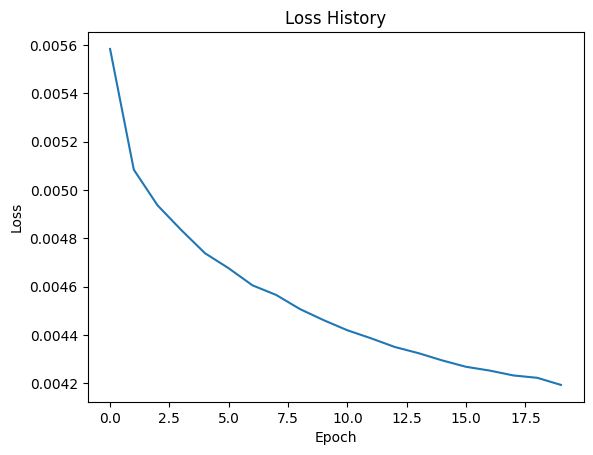

In [11]:
from matplotlib import pyplot as plt
import numpy as np
# plot the loss history
# normalize the loss history
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss History")
plt.show()

In [12]:
# differences in input i = 0 and i = 1
print(all_node_feature[0][0])
print(all_node_feature[1][0])
print(all_node_feature[0][1])
print(all_node_feature[1][1])

tensor([[-0.8562, -0.8562, -0.5519, -0.8562,  2.1862, -0.5519, -0.8562,  3.4032,
         -0.8562],
        [ 0.0566, -0.5519, -0.2477,  0.0566,  1.2735, -0.2477,  1.2735,  1.2735,
         -0.5519],
        [ 1.2735, -0.5519, -0.5519,  2.1862, -0.8562, -0.5519,  3.4032, -0.8562,
         -0.2477]])
tensor([[-0.8644, -0.8644, -0.6937, -0.8644,  2.0374, -0.6937, -0.8644,  3.4029,
         -0.8644],
        [-0.5230, -0.6937, -0.5230, -0.5230,  1.6960, -0.5230,  0.3304,  2.2081,
         -0.6937],
        [ 0.1597, -0.6937, -0.5230,  0.5011,  0.6718, -0.5230,  1.5253,  1.0132,
         -0.5230],
        [-0.5230, -0.6937, -0.5230,  0.8425,  0.3304, -0.5230,  2.2081,  0.3304,
         -0.3523],
        [ 0.3304, -0.6937, -0.6937,  2.0374, -0.8644, -0.6937,  3.4029, -0.8644,
         -0.1816]])
tensor([[-0.8562, -0.8562, -0.5519, -0.8562,  2.7947, -0.5519, -0.8562,  1.8820,
         -0.8562],
        [ 0.9693, -0.5519, -0.2477,  0.9693,  0.9693, -0.2477,  0.9693,  0.0566,
         -0.5519]

In [14]:
from sklearn.metrics import r2_score

test_label_delay = [
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_delay_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_delay_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_delay_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_delay_stage8.pt"))])
]

test_label_slew = [
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_slew_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_slew_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_slew_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_slew_stage8.pt"))])
]

test_node_feature = [
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_node_feature_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_node_feature_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_node_feature_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_node_feature_stage8.pt"))])
]

test_edge_index = [
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_edge_index_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_edge_index_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_edge_index_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_edge_index_stage8.pt"))])
]

test_edge_weight = [
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_edge_weight_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_edge_weight_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_edge_weight_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_edge_weight_stage8.pt"))])
]

test_path_indices = [
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_path_indices_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_path_indices_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_path_indices_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_path_indices_stage8.pt"))])
]

test_path_feature = [
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_path_feature_stage2.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_path_feature_stage4.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_path_feature_stage6.pt"))]),
    torch.stack([t for t in torch.load(os.path.join(TEST_DIR, "test_path_feature_stage8.pt"))])
]

# calculate the R2 score
pred_slew = []
pred_delay = []
target_slew = []
target_delay = []

stage_id = 0

for i in range(len(test_label_delay[stage_id])):
    node_feature = test_node_feature[stage_id][i]
    edge_idx = test_edge_index[stage_id][i]
    edge_weight = test_edge_weight[stage_id][i]
    path_idx = test_path_indices[stage_id][i]
    path_feature = test_path_feature[stage_id][i]
    slew_target = test_label_slew[stage_id][i]
    delay_target = test_label_delay[stage_id][i]

    slew, delay = GNN(node_feature, edge_idx, edge_weight, path_idx, path_feature)
    pred_slew.append(slew.item())
    pred_delay.append(delay.item())
    target_slew.append(slew_target.item())
    target_delay.append(delay_target.item())

print("predicted slew: ", pred_slew)
print("target slew: ", target_slew)
print("predicted delay: ", pred_delay)
print("target delay: ", target_delay)

print("R2 score for slew: ", r2_score(target_slew, pred_slew))
print("R2 score for delay: ", r2_score(target_delay, pred_delay))

predicted slew:  [0.0898239016532898, 0.07507060468196869, 0.1609438955783844, 0.11184506863355637, 0.15875029563903809, 0.10493156313896179, 0.12411805242300034, 0.11067456752061844, 0.21327117085456848, 0.10033746063709259, 0.11746520549058914, 0.11710094660520554, 0.10178875178098679, 0.08083394169807434, 0.1929427683353424, 0.07316116243600845, 0.147273987531662, 0.08802071213722229, 0.1809290051460266, 0.10685431957244873, 0.12738266587257385, 0.17190638184547424, 0.18750765919685364, 0.08770828694105148, 0.15241149067878723, 0.06735013425350189, 0.1680663824081421, 0.09677273780107498, 0.09600568562746048, 0.12691456079483032, 0.06368967890739441, 0.13972020149230957, 0.11332724243402481, 0.06149597465991974, 0.1826746165752411, 0.1400209367275238, 0.22717085480690002, 0.08651014417409897, 0.09967721998691559, 0.12722578644752502, 0.1872972846031189, 0.12448251992464066, 0.09581363946199417, 0.07180504500865936, 0.2453024685382843, 0.16321054100990295, 0.14285904169082642, 0.0984

## Reference
- Base : https://colab.research.google.com/github/VisiumCH/AMLD-2021-Graphs/blob/master/notebooks/workshop_notebook.ipynb#scrollTo=7kPXvM8OxMJS
- GraphSAGE : https://colab.research.google.com/drive/1udeUfWJzvMlLO7sGUDGsHo8cRPMicajl?usp=sharing#scrollTo=wTR4wQG31Vtk
- GAT : https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/06-graph-neural-networks.ipynb#scrollTo=6c42fc29